Here is the regular least squares fitting

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.linalg
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def const(x):
    return 1

def linear(x):
    return x

def quad(x):
    return x ** 2

def cubic(x):
    return x ** 3

def quartic(x):
    return x ** 4

def quintic(x):
    return x ** 5

def exp(x):
    return torch.exp(x)

def design_matrix(times, basis):
    mat = torch.Tensor([[func(time) for func in basis] for time in times])
    return mat

def ls_fit(xdata, ydata, psuedo_inv):
    return torch.sum(pseudo_inv * ydata, dim = 1)

def chi_sq(ydata, fit_params, design_mat, inv_cov_mat):
    return ydata.T @ inv_cov_mat @ ydata - fit_params.T @ design_mat.T @ inv_cov_mat @ design_mat @ fit_params

def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])
    
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

tensor(1140.6387)


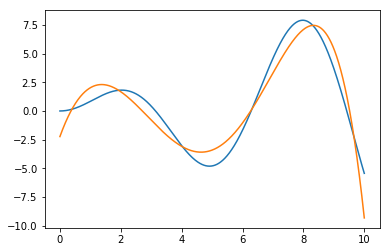

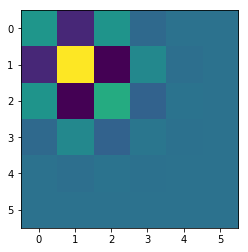

In [2]:
x_data = torch.linspace(0, 10, 1000)
y_data = x_data * torch.sin(x_data)

basis = [const, linear, quad, cubic, quartic, quintic]

cov_mat = torch.eye(1000) # constant variance, no point is better than another
inv_cov_mat = torch.inverse(cov_mat)

design_mat = design_matrix(x_data, basis)
pseudo_inv = torch.linalg.pinv(design_mat)

fit_params = ls_fit(x_data, y_data, pseudo_inv)

fit = torch.sum(design_mat * fit_params, dim=1)

chisq = chi_sq(y_data, fit_params, design_mat, inv_cov_mat)
print(chisq)

plt.plot(x_data, y_data)
plt.plot(x_data, fit)

plt.show()

fit_params_cov_mat = pseudo_inv @ (cov_mat @ pseudo_inv.T)

plt.imshow(fit_params_cov_mat)
plt.show()

We can do better though, if we know the covariance matrix of our input data. We can take that into account when doing the least squares fitting.

Cov_mat positive definite:  True
tensor(221.3677)


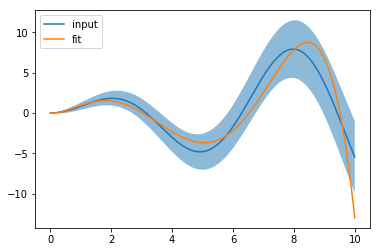

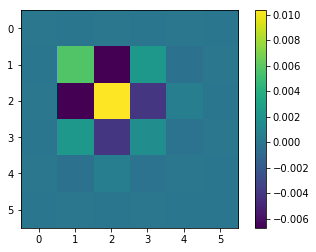

In [3]:
x_data = torch.linspace(0, 10, 1000)
y_data = x_data * torch.sin(x_data)

basis = [const, linear, quad, cubic, quartic, quintic]

inv_cov_mat = 200000 * torch.Tensor(scipy.linalg.hilbert(1000) ** 2) * torch.eye(1000)
cov_mat = torch.inverse(inv_cov_mat)

print("Cov_mat positive definite: ",is_pos_def(cov_mat.numpy()))

#cov_mat = torch.load("saved_tensors/cov_mat_background_0_1000.pt")
#inv_cov_mat = torch.load("saved_tensors/inv_cov_mat_background_0_1000.pt")

design_mat = design_matrix(x_data, basis)
pseudo_inv = torch.inverse(design_mat.T @ inv_cov_mat @ design_mat) @ design_mat.T @ inv_cov_mat

fit_params = ls_fit(x_data, y_data, pseudo_inv)

fit = torch.sum(design_mat * fit_params, dim=1)

chisq = chi_sq(y_data, fit_params, design_mat, inv_cov_mat)
print(chisq)

y_data_upper_err = y_data + torch.sqrt(torch.diag(cov_mat))
y_data_lower_err = y_data - torch.sqrt(torch.diag(cov_mat))

plt.fill_between(x_data, y_data_lower_err, y_data_upper_err, alpha=0.5)
plt.plot(x_data, y_data, label="input")
plt.plot(x_data, fit, label="fit")

plt.legend()

plt.show()

fit_params_cov_mat = pseudo_inv @ (cov_mat @ pseudo_inv.T)

img = plt.imshow(fit_params_cov_mat)
plt.colorbar(img)

plt.show()

The chi square in the case where we know the covariance matrix is much lower. Why? Because I set the variance to be very large. The calculation isn't weighting those points hardly at all, because of the large error bound on them.

Let's try the fit again but with good error bars on the right side of the fit

Cov_mat positive definite:  True
tensor(1383.5742)


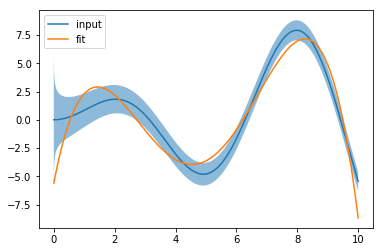

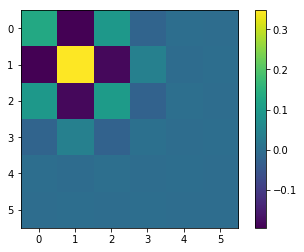

In [5]:
x_data = torch.linspace(0, 10, 1000)
y_data = x_data * torch.sin(x_data)

basis = [const, linear, quad, cubic, quartic, quintic]

cov_mat = torch.sqrt(torch.Tensor(1000 * scipy.linalg.hilbert(1000)) * torch.eye(1000))
inv_cov_mat = torch.inverse(cov_mat)

print("Cov_mat positive definite: ",is_pos_def(cov_mat.numpy()))

design_mat = design_matrix(x_data, basis)
pseudo_inv = torch.inverse(design_mat.T @ inv_cov_mat @ design_mat) @ design_mat.T @ inv_cov_mat

fit_params = ls_fit(x_data, y_data, pseudo_inv)

fit = torch.sum(design_mat * fit_params, dim=1)

chisq = chi_sq(y_data, fit_params, design_mat, inv_cov_mat)
print(chisq)

y_data_upper_err = y_data + torch.sqrt(torch.diag(cov_mat))
y_data_lower_err = y_data - torch.sqrt(torch.diag(cov_mat))

plt.fill_between(x_data, y_data_lower_err, y_data_upper_err, alpha=0.5)
plt.plot(x_data, y_data, label="input")
plt.plot(x_data, fit, label="fit")

plt.legend()

plt.show()

fit_params_cov_mat = pseudo_inv @ (cov_mat @ pseudo_inv.T)

img = plt.imshow(fit_params_cov_mat)
plt.colorbar(img)

plt.show()

In [ ]:
%matplotlib inline

x_data = torch.Tensor([1,2,3])
y_data = torch.Tensor([0.9,1.1,3])

basis = [const, linear]

var1 = 1
var2 = 1
var3 = 1
var12 = 0.0
var13 = 0.0
var23 = 0.0
cov_mat = torch.Tensor([[var1, var12, var13],[var12, var2, var23],[var13, var23, var3]])
inv_cov_mat = torch.inverse(cov_mat)

print("Cov_mat positive definite: ",is_pos_def(cov_mat.numpy()))

design_mat = design_matrix(x_data, basis)
pseudo_inv = torch.inverse(design_mat.T @ inv_cov_mat @ design_mat) @ design_mat.T @ inv_cov_mat

fit_params = ls_fit(x_data, y_data, pseudo_inv)

fit = torch.sum(design_mat * fit_params, dim=1)

chisq = chi_sq(y_data, fit_params, design_mat, inv_cov_mat)
print(chisq)

plt.errorbar(x_data, y_data, yerr=torch.sqrt(torch.diagonal(cov_mat)).numpy(), fmt='o')
plt.plot(x_data, fit,'r')

plt.xlabel("Independent Variable")
plt.ylabel("Dependent Variable")
plt.title("Linear Regression")

plt.show()

fit_params_cov_mat = pseudo_inv @ (cov_mat @ pseudo_inv.T)

img = plt.imshow(fit_params_cov_mat)
plt.colorbar(img)
plt.show()

In [ ]:
%matplotlib qt

from matplotlib.colors import LightSource

# First the ellipse

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones_like(u), np.cos(v))

bias=np.array(y_data).T

ellipsoid = (cov_mat.numpy() @ np.stack((x,y,z), 0).reshape(3,-1) + bias[:, np.newaxis]).reshape(3, *x.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ls = LightSource(azdeg=0, altdeg=65)
rgb = ls.shade(z, plt.cm.Blues)

ax.plot_surface(*ellipsoid, rstride=4, cstride=4, color='b', alpha=0.5, facecolors=rgb,linewidth=0)

# Set the axes to be equal
set_axes_equal(ax)

ax.set_aspect('equal')


# Now the plane

point = np.array([0,0,0])
normal = np.array([x_data[1] - x_data[2], x_data[2] - x_data[0], x_data[0] - x_data[1]])

d = -point.dot(normal)

xx, yy = np.meshgrid(np.linspace(-1, 2, 10), np.linspace(-1, 2, 10))
z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]

rgb = ls.shade(z, plt.cm.Reds)

ax.plot_surface(xx, yy, z, color='r', alpha=0.2,facecolors=rgb,linewidth=0)

ax.scatter(y_data[0].item(), y_data[1].item(), y_data[2].item(),'k')
ax.scatter(fit[0].item(), fit[1].item(), fit[2].item(),'k')

ax.plot(np.array([y_data[0].item(),fit[0].item()]), np.array([y_data[1].item(),fit[1].item()]), np.array([y_data[2].item(),fit[2].item()]), 'k')

ax.set_xlabel('y1')
ax.set_ylabel('y2')
ax.set_zlabel('y3')

plt.show()

chi = y_data.numpy() - fit.numpy()
print(np.arccos(np.abs(np.dot(chi, normal)) / (np.linalg.norm(chi) * np.linalg.norm(normal))))

In [ ]:
%matplotlib inline

x_data = torch.Tensor([1, 2])
y_data = torch.Tensor([0.9,1.1])

basis = [linear]

var1 = 1
var2 = 1
var12 = 0.99
cov_mat = torch.Tensor([[var1, var12],[var12, var2]])
inv_cov_mat = torch.inverse(cov_mat)

print("Cov_mat positive definite: ",is_pos_def(cov_mat.numpy()))

design_mat = design_matrix(x_data, basis)
pseudo_inv = torch.inverse(design_mat.T @ inv_cov_mat @ design_mat) @ design_mat.T @ inv_cov_mat

fit_params = ls_fit(x_data, y_data, pseudo_inv)

fit = torch.sum(design_mat * fit_params, dim=1)

chisq = chi_sq(y_data, fit_params, design_mat, inv_cov_mat)
print(chisq)

plt.errorbar(x_data, y_data, yerr=torch.sqrt(torch.diagonal(cov_mat)).numpy(), fmt='o')
plt.plot(x_data, fit,'r')

plt.xlabel("Independent Variable")
plt.ylabel("Dependent Variable")
plt.title("Linear Regression")

plt.savefig("linear_regression_sample.png",dpi=400)
plt.show()

fit_params_cov_mat = pseudo_inv @ (cov_mat @ pseudo_inv.T)

img = plt.imshow(fit_params_cov_mat)
plt.colorbar(img)
plt.show()

Let's visualize that similar to how we were doing it before

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(8,8))

pearson = cov_mat[0, 1] / torch.sqrt(cov_mat[0, 0] * cov_mat[1, 1])

# Using a special case to obtain the eigenvalues of this
# two-dimensionl dataset.
ell_radius_y1 = torch.sqrt(1 + pearson)
ell_radius_y2 = torch.sqrt(1 - pearson)

ellipse = Ellipse((0, 0), width=ell_radius_y1 * 2, height=ell_radius_y2 * 2, edgecolor='k', facecolor='blue',alpha=0.1)

scale_y1 = torch.sqrt(cov_mat[0,0])
mean_y1 = y_data[0]

scale_y2 = torch.sqrt(cov_mat[1,1])
mean_y2 = y_data[1]

transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_y1, scale_y2) \
        .translate(mean_y1, mean_y2)


ellipse.set_transform(transf + ax.transData)

ax.add_patch(ellipse)

ax.set_aspect('equal')

plt.plot([mean_y1, fit[0]], [mean_y2, fit[1]], 'k')

plt.scatter(mean_y1, mean_y2, c = 'k')
plt.scatter(fit[0], fit[1], c = 'r')

xx = torch.linspace(fit[0] - 0.5, fit[1] + 0.2,2).numpy()
yy = x_data[1].item() / x_data[0].item() * xx

line = np.array([xx[0] - xx[1], yy[0] - yy[1]])

plt.plot(xx, yy,'r')

plt.show()

chi = y_data.numpy() - fit.numpy()
print("Standard dot product angle (deg): ", 180 / np.pi * np.arccos(np.abs(np.dot(chi, line)) / (np.linalg.norm(chi) * np.linalg.norm(line))))

g = inv_cov_mat.numpy() # metric tensor

print("Weird metric dot product angle (deg): ", 180 / np.pi * np.arccos(np.abs(line @ g @ chi) / (np.sqrt(chi @ g @ chi) * np.sqrt(line @ g @ line))))